In [1]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
)

In [2]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [3]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [4]:
categorical_features = ["lead_source", "industry", "employment_status", "location"]
numerical_features = [
    "lead_score",
    "number_of_courses_viewed",
    "interaction_count",
    "annual_income",
]
target_variable = "converted"

In [5]:
df.isna().sum() / df.shape[0] * 100

lead_source                  8.755130
industry                     9.165527
number_of_courses_viewed     0.000000
annual_income               12.380301
employment_status            6.839945
location                     4.309166
interaction_count            0.000000
lead_score                   0.000000
converted                    0.000000
dtype: float64

In [6]:
# Check if the missing values are presented in the features.
# If there are missing values:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0

for col in df.columns:
    df[col] = (
        df[col].fillna("NA") if col in categorical_features else df[col].fillna(0.0)
    )

In [7]:
df.isna().sum() / df.shape[0] * 100

lead_source                 0.0
industry                    0.0
number_of_courses_viewed    0.0
annual_income               0.0
employment_status           0.0
location                    0.0
interaction_count           0.0
lead_score                  0.0
converted                   0.0
dtype: float64

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

# train is now 60% of the entire data set
# test is 40% but we will split it again
df_train, df_test = train_test_split(
    df,
    test_size=1 - train_ratio,
    random_state=1,
)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
df_test, df_val = train_test_split(
    df_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=1,
)

y_train = df_train[target_variable].values
y_test = df_test[target_variable].values
y_val = df_val[target_variable].values

df_train = df_train.drop(columns=target_variable)
df_test = df_test.drop(columns=target_variable)
df_val = df_val.drop(columns=target_variable)

np.array([df_train.shape[0], df_val.shape[0], df_test.shape[0]]) / df.shape[0]

array([0.5998632, 0.2004104, 0.1997264])

In [9]:
from sklearn.metrics import roc_auc_score

for feat in numerical_features:
    # use numerical feature as predicted result
    yp = df_train[feat]

    # use the target variable (y_train) as the ground truth
    auc = roc_auc_score(y_true=y_train, y_score=yp)
    print(f"{feat=} {auc=}")

feat='lead_score' auc=0.6111168681007025
feat='number_of_courses_viewed' auc=0.7652439024390244
feat='interaction_count' auc=0.7271914132379249
feat='annual_income' auc=0.5446354552990968


In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


def train(df_train, y_train, C):
    dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver="liblinear")
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)

auc_score = round(roc_auc_score(y_true=y_val, y_score=y_pred), 3)
print(auc_score)

0.8


In [11]:
answers = [0.32, 0.52, 0.72, 0.92]
how_close = np.zeros(len(answers))
for idx, answer in enumerate(answers):
    how_close[idx] = abs(auc_score - answer)

answers[how_close.argmin()]

0.72

In [12]:
def get_precision_recall(
    y_val: np.ndarray, y_pred: np.ndarray, threshold: float
) -> tuple[float, float]:
    # we predicted 1 when it was actually 1 (true)
    tp = ((y_val == 1) & (y_pred >= threshold)).sum()

    # we predicted 1 when it was actually 0 (false)
    fp = ((y_val == 0) & (y_pred >= threshold)).sum()

    # we predicted 0 and it was actually 0
    # tn = ((y_val == 0) & (y_pred < 0.5)).sum()

    # we predicted 0 and it was actually 1
    fn = ((y_val == 1) & (y_pred < threshold)).sum()

    # precision (how many things did i get right from all the things i predicted)
    precision = tp / (tp + fp)

    # recall (how many things did I get right from the things that are relevant)
    recall = tp / (tp + fn)

    # f1 (harmonic mean of p and r)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

In [13]:
pr = np.array(
    [
        get_precision_recall(y_val, y_pred, thresh)
        for thresh in np.arange(start=0, stop=0.98, step=0.01)
    ]
)

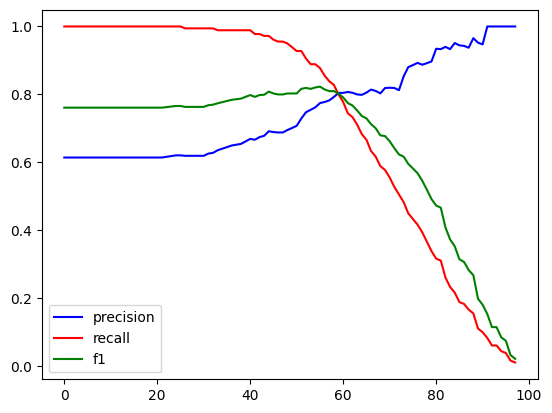

In [14]:
import matplotlib.pyplot as plt

plt.plot(pr[:, 0], label="precision", c="blue")
plt.plot(pr[:, 1], label="recall", c="red")
plt.plot(pr[:, 2], label="f1", c="green")
plt.legend()

In [15]:
# At which threshold precision and recall curves intersect?
min_idx = np.argmin(abs(pr[:, 0] - pr[:, 1]))
np.arange(0, 0.99, 0.01)[min_idx]

np.float64(0.59)

In [16]:
# At which threshold F1 is maximal?
max_idx = np.argmax(pr[:, 2])
np.arange(0, 0.99, 0.01)[max_idx]

np.float64(0.55)

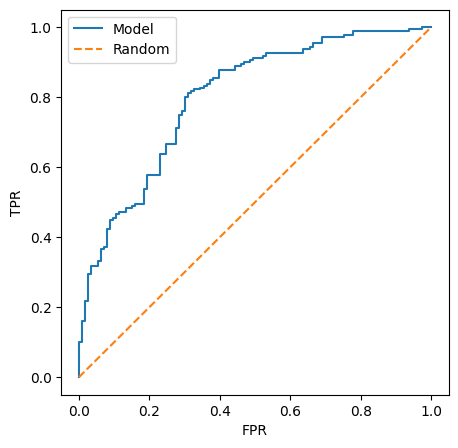

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [38]:
from sklearn.model_selection import KFold
from tqdm import tqdm

# Create train/test split for K-fold validation (keeping target variable in df_full_train)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # Extract target variable and features
    y_train = df_train[target_variable].values
    y_val = df_val[target_variable].values

    # Remove target variable from training and validation sets
    df_train_features = df_train.drop(columns=[target_variable])
    df_val_features = df_val.drop(columns=[target_variable])

    dv, model = train(df_train_features, y_train, C=1)
    y_pred = predict(df_val_features, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"{np.mean(scores)=:.3f}, {np.std(scores)=:.3f}")

np.mean(scores)=0.822, np.std(scores)=0.036


In [37]:
from sklearn.model_selection import KFold
from tqdm import tqdm

# Create train/test split for K-fold validation (keeping target variable in df_full_train)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train[target_variable].values
        y_val = df_val[target_variable].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

100%|██████████| 3/3 [00:00<00:00, 26.75it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
